My goal is to build a model for the inference we are trying to perform. To reiterate, my goal is to build a model that infers both the dark matter mass of each individual cluster and the global DMM/richness relation. This model will be constrained with simulation data, which will give us the richness and redshift of a galaxy cluster. 

The DMM/Richness relation is assumed to be of the form:

$\lambda = aM^b+\sigma$ 

Where $a,b$ are free parameters and $\sigma$ is some scatter. I'll sketch a PGM of this model below. 

At this moment, I'm confused as to how the richness and redshift alone can constrain individual masses. I will try to talk to Matt Becker tomorrow about it. I spoke to Joe for a minute at my desk about it, and he thinks it's possible that, given a mass function it is possible to constrain mass with lambda and redshift (sorta?). I'm still not 100% sure about it. 

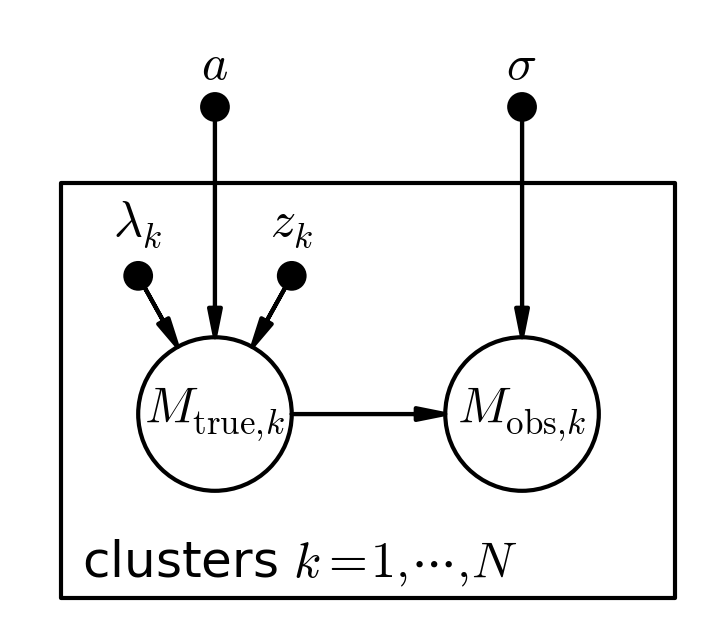

In [2]:
import daft

pgm = daft.PGM([2.3, 2.05], origin=[.3,.3], grid_unit = 2.6, node_unit=1.3, observed_style="inner")

pgm.add_node(daft.Node("a", r"$a$", 1,2,fixed =True))
pgm.add_node(daft.Node("scatter", r"$\sigma$", 2, 2, fixed = True))

pgm.add_node(daft.Node("richness", r"$\lambda_k$", .75,1.45,fixed =True))
pgm.add_node(daft.Node("redshift", r"$z_k$", 1.25,1.45,fixed =True))

pgm.add_node(daft.Node("Mtrue", r"$M_{{\rm true},k}$", 1,1))

pgm.add_node(daft.Node("Mobs", r"$M_{{\rm obs},k}$", 2,1))

pgm.add_edge("a", "Mtrue")
pgm.add_edge("richness", "Mtrue")
pgm.add_edge("redshift", "Mtrue")
pgm.add_edge("Mtrue", "Mobs")
pgm.add_edge("scatter", "Mobs")

pgm.add_plate(daft.Plate([.5,.5,2,1.25], label=r"clusters $k=1, \cdots, N$", shift = -.1))

pgm.render()
pgm.figure.savefig("modelPGM.png", dpi = 300)
from IPython.display import Image
Image("modelPGM.png")

#### 10/5/15
I met with Matt Becker and went over the details of the model and I feel a little better about a few things. We tinkered with it and got to a more correct version of our model.

I asked Matt about whether or not we would be using the simulation masses or inferring them somehow. He said what we'd probably do is marginalize over them, which makes more sense. 

As for our next step, he said the first thing we'd do is assume some simple model and try to analytically integrate over it. After that, we can inject more complexity into the model and try something more crazy like MCMC or the like. 

Below I've thrown down what me and Matt got to for the PGM.

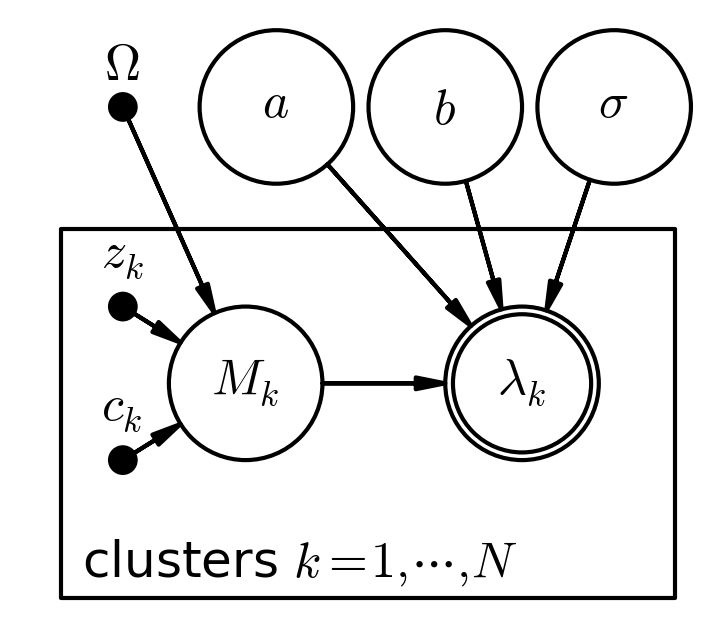

In [13]:
import daft

pgm = daft.PGM([2.3, 2.05], origin=[.3,.3], grid_unit = 2.6, node_unit=1.3, observed_style="inner")

pgm.add_node(daft.Node("cosmology", r"$\Omega$", .7,2,fixed =True))

pgm.add_node(daft.Node("scatter", r"$\sigma$", 2.3, 2))
pgm.add_node(daft.Node("b", r"$b$", 1.75, 2))
pgm.add_node(daft.Node("a", r"$a$", 1.2, 2))

pgm.add_node(daft.Node("redshift", r"$z_k$", 0.7,1.35,fixed =True))
pgm.add_node(daft.Node("class", r"$c_k$", 0.7, .85, fixed = True))

pgm.add_node(daft.Node("Mcluster", r"$M_k$", 1.1,1.1))

pgm.add_node(daft.Node("richness", r"$\lambda_k$", 2,1.1,observed=True))

pgm.add_edge("a", "richness")
pgm.add_edge("b", "richness")
pgm.add_edge("scatter", "richness")
pgm.add_edge("Mcluster", "richness")

pgm.add_edge("redshift", "Mcluster")
pgm.add_edge("class", "Mcluster")
pgm.add_edge("cosmology", "Mcluster")

pgm.add_plate(daft.Plate([.5,.5,2,1.1], label=r"clusters $k=1, \cdots, N$", shift = -.1))

pgm.render()
pgm.figure.savefig("modelPGM2.png", dpi = 300)
from IPython.display import Image
Image("modelPGM2.png")

This PGM decomposes to the following product:

$\prod_{k=1}^{N}{P(\lambda_k | M_k, a,b,\sigma)\, P(M_k | z_k, c_k, \Omega)\, P(a)\, P(b)\, P(\sigma)} = P(a)\, P(b)\, P(\sigma)\, \prod_{k=1}^{N}{P(\lambda_k | M_k, a,b,\sigma)\, P(M_k | z_k, c_k, \Omega)} $ 

Matt said this is where we would stop, but I thought that we would want to integrate over this, especially if we were trying to marginalize over $\{M_k\}$. If that is true, we'd be left with the following. 

$\int{P(a)\, P(b)\, P(\sigma)\, \prod_{k=1}^{N}{P(\lambda_k | M_k, a,b,\sigma)\, P(M_k | z_k, c_k, \Omega)}\, da\, db\, d\sigma\, d\{M_k\}} = P(a,b | \{\lambda_k\}) $

Which after writing it out seems

1. Hard, especially over $\{M_k\}$

2. Unecessary, because that's kind of implicitly what we're doing. We have the posterior already above. 



I also just had Phil pop by and talk for like 20-30 minutes. I showed him what I was working on and the papers that I printed up. He said that they looked good but emphasized some caution. He had the same confusion I did about hwo we're going to get mass information into the model. He said we may inject some weak lensing, or use the mass function to infer things. He also said we should see what kind of data we have from the catalogs to get a handle on how we would approach it.

He also said that another option for this would be to train on the simulations and use that trained model to make predictions (yeah machine learning!). It's unclear if we'll take that route. 

So, he wants the same thing Matt wants (thinking about inferring mass) and also for me to just play with the data some more. Can do (after I apply to the NSF). He said that we're trying to find the simplest place to start, which is challenging to do. 